# 🚀 TFT Training Quick Start

## Simplified workflow for dataset creation and model training

This notebook does two things:
1. **Generate training dataset** - Create realistic server metrics data
2. **Train TFT model** - Train the Temporal Fusion Transformer

The dashboard and inference daemon handle everything else!

---

**⏱️ Estimated Times:**
- Dataset generation (24h): ~30-60 seconds
- Dataset generation (720h): ~5-10 minutes
- Model training (10 epochs): ~3-5 hours on RTX 4090

**🎯 After Training:**
- Start system: `start_all.bat` (Windows) or `./start_all.sh` (Linux/Mac)
- Dashboard: http://localhost:8050
- API: http://localhost:8000

In [1]:
# Cell 1: Setup and Configuration
import sys
import time
from pathlib import Path

# Add src/ to Python path (works from either root or NordIQ directory)
current_dir = Path.cwd()
if current_dir.name == 'NordIQ':
    # Notebook is in NordIQ folder
    nordiq_src = (current_dir / 'src').absolute()
    nordiq_root = current_dir
else:
    # Notebook is in root folder
    nordiq_src = (current_dir / 'NordIQ' / 'src').absolute()
    nordiq_root = current_dir / 'NordIQ'

if str(nordiq_src) not in sys.path:
    sys.path.insert(0, str(nordiq_src))

print("🎯 TFT Training System")
print("=" * 70)
print("✅ Python path configured")
print(f"📁 NordIQ source: {nordiq_src}")
print(f"📁 NordIQ root: {nordiq_root}")
print("\n🔧 Configuration:")
print(f"   Training directory: {nordiq_root}/training/")
print(f"   Models directory: {nordiq_root}/models/")
print("   Prediction horizon: 96 steps (8 hours)")
print("   Context length: 288 steps (24 hours)")
print("=" * 70)

🎯 TFT Training System
✅ Python path configured
📁 NordIQ source: D:\Vibe_Projects\MonitoringPrediction\NordIQ\src
📁 NordIQ root: D:\Vibe_Projects\MonitoringPrediction\NordIQ

🔧 Configuration:
   Training directory: D:\Vibe_Projects\MonitoringPrediction\NordIQ/training/
   Models directory: D:\Vibe_Projects\MonitoringPrediction\NordIQ/models/
   Prediction horizon: 96 steps (8 hours)
   Context length: 288 steps (24 hours)


---

## System Health Check

Verify your environment is ready for training:

In [2]:
# Cell 2: Comprehensive System Check
# Verify GPU, Python environment, dependencies, and system readiness

import sys
import platform
from pathlib import Path
import importlib.util

# Setup paths (same as Cell 1)
current_dir = Path.cwd()
if current_dir.name == 'NordIQ':
    nordiq_src = (current_dir / 'src').absolute()
    nordiq_root = current_dir
else:
    nordiq_src = (current_dir / 'NordIQ' / 'src').absolute()
    nordiq_root = current_dir / 'NordIQ'

if str(nordiq_src) not in sys.path:
    sys.path.insert(0, str(nordiq_src))

print("╔" + "═" * 68 + "╗")
print("║" + " " * 20 + "SYSTEM HEALTH CHECK" + " " * 29 + "║")
print("╚" + "═" * 68 + "╝")
print()

# ============================================================================
# 1. PYTHON ENVIRONMENT
# ============================================================================
print("┌─ Python Environment " + "─" * 47 + "┐")
print(f"│ Python Version:     {platform.python_version():<46}│")
print(f"│ Platform:           {platform.system()} {platform.release():<36}│")
print(f"│ Architecture:       {platform.machine():<46}│")

# Working directory - handle long paths gracefully
cwd = str(Path.cwd())
if len(cwd) <= 45:
    print(f"│ Working Directory:  {cwd:<46}│")
else:
    # Split long paths across multiple lines
    print(f"│ Working Directory:                                          │")
    # Show path in chunks of 60 characters
    chunk_size = 60
    for i in range(0, len(cwd), chunk_size):
        chunk = cwd[i:i+chunk_size]
        print(f"│   {chunk:<64}│")

# Show NordIQ root detection
nordiq_root_str = str(nordiq_root)
if len(nordiq_root_str) <= 45:
    print(f"│ NordIQ Root:        {nordiq_root_str:<46}│")
else:
    print(f"│ NordIQ Root:                                                │")
    for i in range(0, len(nordiq_root_str), chunk_size):
        chunk = nordiq_root_str[i:i+chunk_size]
        print(f"│   {chunk:<64}│")

print("└" + "─" * 68 + "┘")
print()

# ============================================================================
# 2. GPU AVAILABILITY & PYTORCH CUDA CHECK
# ============================================================================
print("┌─ GPU Status " + "─" * 54 + "┐")

gpu_available = False
gpu_name = "Not available"
gpu_memory = 0
cuda_version = "N/A"
torch_cuda_enabled = False
pytorch_installed = False

try:
    import torch
    pytorch_installed = True
    torch_cuda_enabled = torch.cuda.is_available()
    gpu_available = torch_cuda_enabled
    
    if torch_cuda_enabled:
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        cuda_version = torch.version.cuda
        
        print(f"│ ✅ GPU Detected:     {gpu_name[:45]:<45}│")
        print(f"│    CUDA Version:     {cuda_version:<46}│")
        print(f"│    Memory:           {gpu_memory:.1f} GB{' ' * 42}│")
        print(f"│    PyTorch CUDA:     Enabled{' ' * 40}│")
        
        # GPU utilization
        try:
            import subprocess
            result = subprocess.run(['nvidia-smi', '--query-gpu=utilization.gpu,memory.used,memory.total', 
                                   '--format=csv,noheader,nounits'], 
                                  capture_output=True, text=True, timeout=2)
            if result.returncode == 0:
                gpu_util, mem_used, mem_total = result.stdout.strip().split(',')
                print(f"│    Utilization:      {gpu_util.strip()}%{' ' * 43}│")
                print(f"│    Memory Used:      {mem_used.strip()} MB / {mem_total.strip()} MB{' ' * 28}│")
        except:
            pass
            
    else:
        # PyTorch installed but CUDA not available
        print("│ ⚠️  PyTorch installed but CUDA not enabled{' ' * 24}│")
        print(f"│    PyTorch Version:  {torch.__version__:<46}│")
        print(f"│    CUDA Built:       {torch.version.cuda if torch.version.cuda else 'No (CPU-only)':<46}│")
        print(f"│    CUDA Available:   {torch_cuda_enabled}{' ' * 41}│")
        print("│{' ' * 68}│")
        print("│ ⚠️  Training will use CPU (20-40x slower){' ' * 25}│")
        print("│    Expected time:    10 epochs ≈ 20-40 hours{' ' * 21}│")
        print("│{' ' * 68}│")
        print("│ 💡 To enable GPU:{' ' * 50}│")
        print("│    1. Verify NVIDIA GPU is present (nvidia-smi){' ' * 19}│")
        print("│    2. Install CUDA Toolkit (nvidia.com/cuda){' ' * 22}│")
        print("│    3. Reinstall PyTorch with CUDA:{' ' * 34}│")
        print("│       pip uninstall torch{' ' * 42}│")
        print("│       pip install torch --index-url{' ' * 30}│")
        print("│         https://download.pytorch.org/whl/cu121{' ' * 20}│")
        
except ImportError:
    print("│ ❌ PyTorch not installed{' ' * 42}│")
    print("│{' ' * 68}│")
    print("│ Install with GPU support:{' ' * 42}│")
    print("│   pip install torch --index-url{' ' * 34}│")
    print("│     https://download.pytorch.org/whl/cu121{' ' * 24}│")

print("└" + "─" * 68 + "┘")
print()

# ============================================================================
# 3. CRITICAL DEPENDENCIES
# ============================================================================
print("┌─ Critical Dependencies " + "─" * 43 + "┐")

dependencies = {
    'torch': 'PyTorch (Deep Learning)',
    'lightning': 'PyTorch Lightning (Training)',
    'pandas': 'Pandas (Data Processing)',
    'numpy': 'NumPy (Numerical Computing)',
    'pytorch_forecasting': 'PyTorch Forecasting (TFT Model)',
    'fastapi': 'FastAPI (Inference API)',
    'plotly': 'Plotly (Dashboard)',
    'dash': 'Dash (Dashboard Framework)'
}

missing_deps = []
installed_deps = []

for package, description in dependencies.items():
    spec = importlib.util.find_spec(package)
    if spec is not None:
        try:
            module = importlib.import_module(package)
            version = getattr(module, '__version__', 'unknown')
            status = "✅"
            installed_deps.append(package)
            pkg_display = f"{package} ({version})"
        except:
            status = "⚠️"
            pkg_display = package
    else:
        status = "❌"
        missing_deps.append(package)
        pkg_display = package
    
    print(f"│ {status} {pkg_display:<63}│")

print("└" + "─" * 68 + "┘")
print()

# ============================================================================
# 4. DIRECTORY STRUCTURE
# ============================================================================
print("┌─ Directory Structure " + "─" * 46 + "┐")

required_dirs = {
    'training': nordiq_root / 'training',
    'models': nordiq_root / 'models',
    'checkpoints': nordiq_root / 'checkpoints',
    'logs': nordiq_root / 'logs'
}

for name, path in required_dirs.items():
    exists = path.exists()
    status = "✅" if exists else "⚠️"
    existence = "exists" if exists else "will be created"
    print(f"│ {status} {name + '/':20} {existence:<44}│")

print("└" + "─" * 68 + "┘")
print()

# ============================================================================
# 5. EXISTING MODELS CHECK
# ============================================================================
print("┌─ Existing Models " + "─" * 50 + "┐")

models_dir = nordiq_root / 'models'
if models_dir.exists():
    model_dirs = sorted(models_dir.glob('tft_model_*'), reverse=True)
    
    if model_dirs:
        print(f"│ Found {len(model_dirs)} trained model(s):{' ' * 40}│")
        for i, model_dir in enumerate(model_dirs[:3], 1):  # Show last 3
            model_name = model_dir.name
            model_size = sum(f.stat().st_size for f in model_dir.rglob('*') if f.is_file()) / (1024**2)
            print(f"│   {i}. {model_name:<40} ({model_size:>6.1f} MB) │")
        if len(model_dirs) > 3:
            print(f"│   ... and {len(model_dirs) - 3} more{' ' * 44}│")
    else:
        print("│ No trained models found - ready for first training{' ' * 16}│")
else:
    print("│ Models directory will be created on first training{' ' * 16}│")

print("└" + "─" * 68 + "┘")
print()

# ============================================================================
# 6. OVERALL READINESS
# ============================================================================
print("╔" + "═" * 68 + "╗")

all_critical_deps = all(dep in installed_deps for dep in ['torch', 'lightning', 'pandas', 'pytorch_forecasting'])

if all_critical_deps and torch_cuda_enabled:
    print("║" + " " * 15 + "✅ SYSTEM READY FOR TRAINING" + " " * 24 + "║")
    print("║" + " " * 15 + f"Estimated: 10 epochs ≈ 3-5 hours on {gpu_name[:20]}" + " " * (12 - len(gpu_name[:20])) + "║")
elif all_critical_deps and pytorch_installed and not torch_cuda_enabled:
    print("║" + " " * 10 + "⚠️  PYTORCH INSTALLED WITHOUT CUDA SUPPORT" + " " * 16 + "║")
    print("║" + " " * 15 + "Training will be 20-40x slower on CPU" + " " * 15 + "║")
    print("║" + " " * 15 + "Estimated: 10 epochs ≈ 20-40 hours" + " " * 19 + "║")
else:
    print("║" + " " * 12 + "❌ MISSING DEPENDENCIES - INSTALL FIRST" + " " * 17 + "║")
    if missing_deps:
        print("║" + " " * 15 + f"Missing: {', '.join(missing_deps)}" + " " * (53 - len(', '.join(missing_deps))) + "║")

print("╚" + "═" * 68 + "╝")
print()

# Clean up
if not all_critical_deps:
    print("⚠️  Install missing packages:")
    print("   pip install torch lightning pandas pytorch-forecasting fastapi plotly dash")
    print()
elif pytorch_installed and not torch_cuda_enabled:
    print("💡 GPU training available but PyTorch lacks CUDA support")
    print("   Reinstall PyTorch with CUDA:")
    print("   pip uninstall torch")
    print("   pip install torch --index-url https://download.pytorch.org/whl/cu121")
    print()

╔════════════════════════════════════════════════════════════════════╗
║                    SYSTEM HEALTH CHECK                             ║
╚════════════════════════════════════════════════════════════════════╝

┌─ Python Environment ───────────────────────────────────────────────┐
│ Python Version:     3.10.16                                       │
│ Platform:           Windows 10                                  │
│ Architecture:       AMD64                                         │
│ Working Directory:  D:\Vibe_Projects\MonitoringPrediction         │
│ NordIQ Root:        D:\Vibe_Projects\MonitoringPrediction\NordIQ  │
└────────────────────────────────────────────────────────────────────┘

┌─ GPU Status ──────────────────────────────────────────────────────┐
│ ✅ GPU Detected:     NVIDIA GeForce RTX 4090                      │
│    CUDA Version:     11.8                                          │
│    Memory:           22.5 GB                                          │
│    PyTorc

---

## Dataset Generation

Creates realistic server metrics with:
- 7 server profiles (ML, DB, Web, Conductor, ETL, Risk, Generic)
- Financial market hours patterns
- 14 LINBORG-compatible metrics

**Adjust parameters below:**

In [ ]:
# Cell 2: Generate Training Dataset
# Expected time: 24h=30-60s | 720h=5-10min

import sys
import time
from pathlib import Path
import pandas as pd

# Add src/ to Python path (works from either root or NordIQ directory)
current_dir = Path.cwd()
if current_dir.name == 'NordIQ':
    # Notebook is in NordIQ folder
    nordiq_src = (current_dir / 'src').absolute()
    nordiq_root = current_dir
else:
    # Notebook is in root folder
    nordiq_src = (current_dir / 'NordIQ' / 'src').absolute()
    nordiq_root = current_dir / 'NordIQ'

if str(nordiq_src) not in sys.path:
    sys.path.insert(0, str(nordiq_src))

# ============================================
# CONFIGURATION - ADJUST THESE VALUES
# ============================================

TRAINING_HOURS = 24        # Options: 24, 168, 720 (recommended: 720 for production)
NUM_ML_COMPUTE = 5         # ML training nodes
NUM_DATABASE = 4           # Database servers
NUM_WEB_API = 6            # Web/API servers
NUM_CONDUCTOR_MGMT = 1     # Conductor management
NUM_DATA_INGEST = 2        # ETL/streaming servers
NUM_RISK_ANALYTICS = 1     # Risk calculation servers
NUM_GENERIC = 1            # Generic/utility servers

TRAINING_DIR = str(nordiq_root / 'training')

# ============================================

print(f"🏢 Dataset Generation")
print("-" * 70)
print(f"⚙️  Configuration:")
print(f"   Duration: {TRAINING_HOURS} hours ({TRAINING_HOURS/24:.1f} days)")
total_servers = NUM_ML_COMPUTE + NUM_DATABASE + NUM_WEB_API + NUM_CONDUCTOR_MGMT + NUM_DATA_INGEST + NUM_RISK_ANALYTICS + NUM_GENERIC
print(f"   Total servers: {total_servers}")
print(f"   Output: {TRAINING_DIR}")
print()

_start = time.time()

# Import and run generator
from generators.metrics_generator import main as generate_metrics

# Set up command-line arguments for the generator
old_argv = sys.argv
sys.argv = [
    'metrics_generator.py',
    '--hours', str(TRAINING_HOURS),
    '--num_ml_compute', str(NUM_ML_COMPUTE),
    '--num_database', str(NUM_DATABASE),
    '--num_web_api', str(NUM_WEB_API),
    '--num_conductor_mgmt', str(NUM_CONDUCTOR_MGMT),
    '--num_data_ingest', str(NUM_DATA_INGEST),
    '--num_risk_analytics', str(NUM_RISK_ANALYTICS),
    '--num_generic', str(NUM_GENERIC),
    '--out_dir', TRAINING_DIR,
    '--format', 'parquet'
]

try:
    generate_metrics()
    print("\n✅ Dataset generation complete!")
    success = True
except Exception as e:
    print(f"\n❌ Generation failed: {e}")
    success = False
finally:
    sys.argv = old_argv

_elapsed = time.time() - _start
_mins = int(_elapsed // 60)
_secs = int(_elapsed % 60)
print(f"\n⏱️  Execution time: {_mins}m {_secs}s")

if success:
    # Show what was created
    training_path = Path(TRAINING_DIR)
    parquet_files = list(training_path.glob("*.parquet"))
    
    if parquet_files:
        latest = max(parquet_files, key=lambda p: p.stat().st_mtime)
        df = pd.read_parquet(latest)
        
        print(f"\n📊 Dataset Summary:")
        print(f"   File: {latest.name}")
        print(f"   Size: {latest.stat().st_size / (1024*1024):.1f} MB")
        print(f"   Records: {len(df):,}")
        print(f"   Servers: {df['server_name'].nunique()}")
        print(f"   Profiles: {sorted(df['profile'].unique())}")
        print(f"   Time span: {(df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 3600:.1f} hours")
        print(f"\n🎯 Ready for training!")

---

## Dataset Explorer

Executive-level dataset analysis and visualization:

╔════════════════════════════════════════════════════════════════════╗
║                  DATASET ANALYSIS REPORT                           ║
║               ArgusAI Predictive Monitoring                        ║
╚════════════════════════════════════════════════════════════════════╝

📂 Loading dataset: server_metrics.parquet
✅ Loaded 345,600 records

╔════════════════════════════════════════════════════════════════════╗
║                      EXECUTIVE SUMMARY                             ║
╚════════════════════════════════════════════════════════════════════╝

┌─ Dataset Metrics ──────────────────────────────────────────────────┐
│ Total Records:               345,600 samples                        │
│ File Size:                      31.9 MB                           │
│ Time Span:                      24.0 hours (1.0 days)             │
│ Sampling Rate:               14400.8 records/hour                │
│ Date Range:             2025-11-17 20:20                 │
│                   

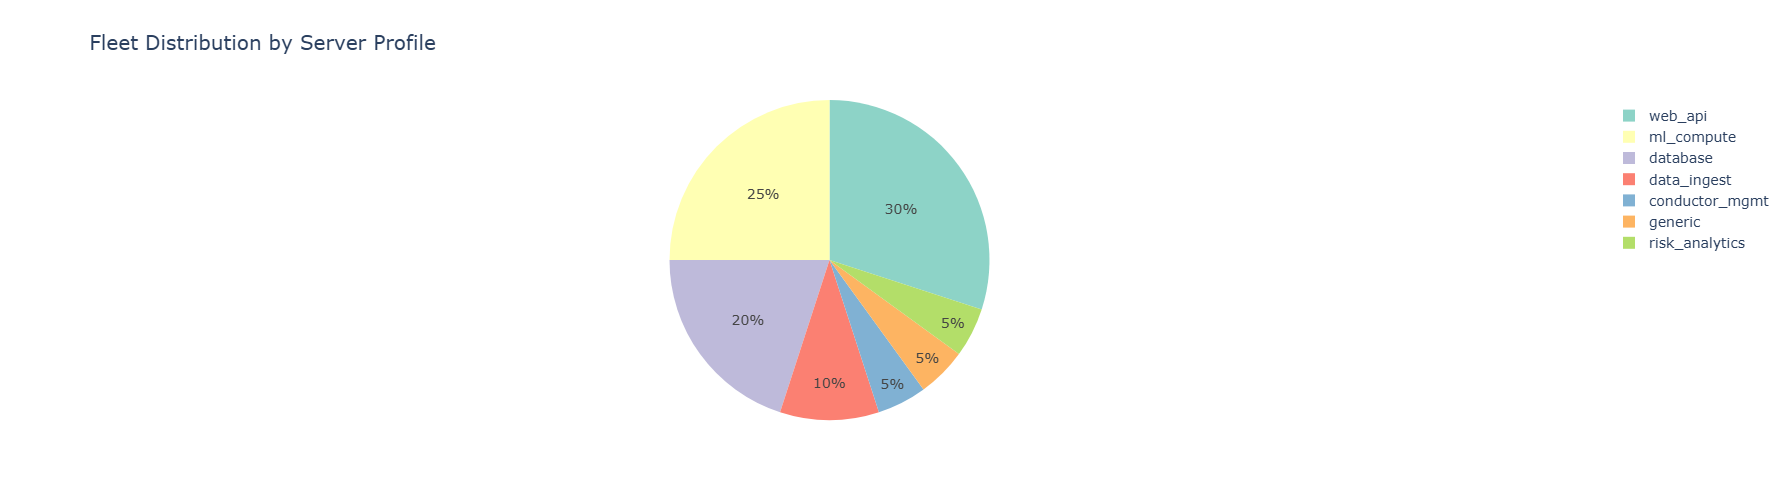

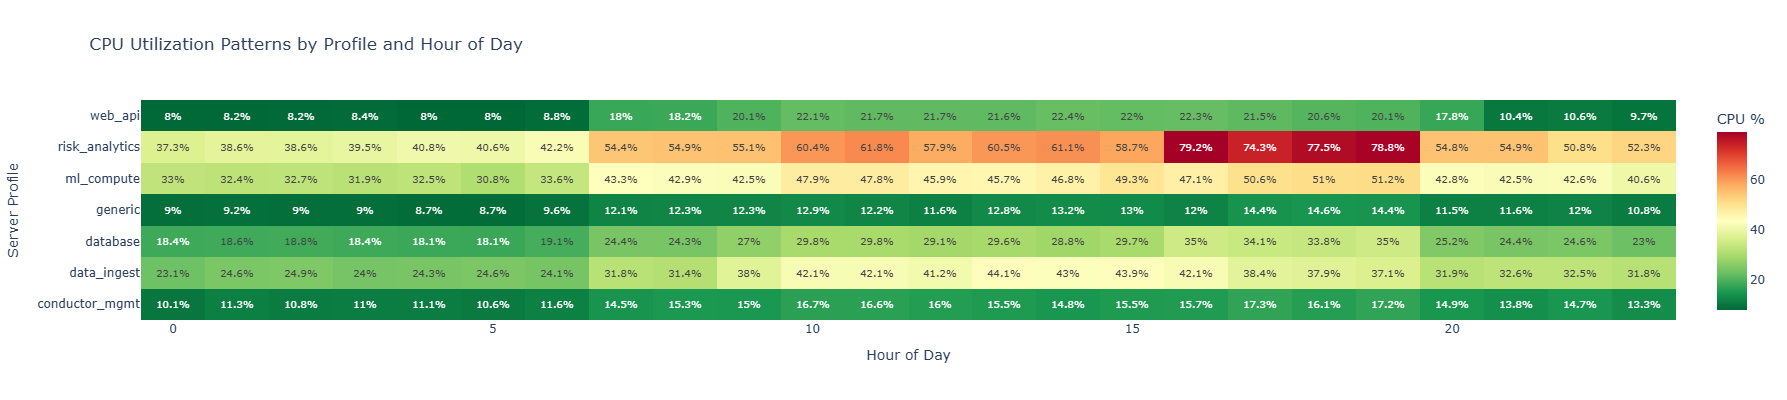

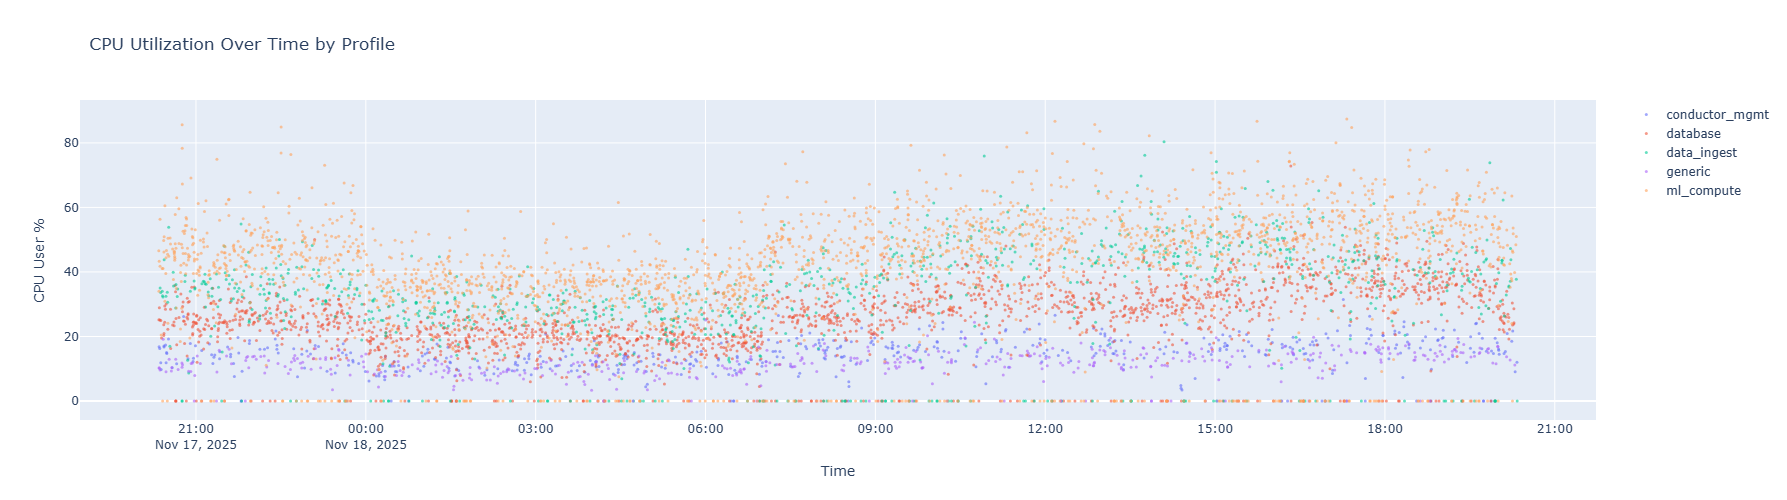


✅ Executive visualizations generated successfully

╔════════════════════════════════════════════════════════════════════╗
║               ✅ DATASET READY FOR TRAINING                       ║
║               345,600 records | 20 servers | 100.0% complete║
╚════════════════════════════════════════════════════════════════════╝



In [3]:
# Dataset Explorer - Executive Presentation View
# Professional analysis with visualizations suitable for C-suite presentations

import sys
from pathlib import Path
import pandas as pd
import numpy as np

# Setup paths
current_dir = Path.cwd()
if current_dir.name == 'NordIQ':
    nordiq_root = current_dir
else:
    nordiq_root = current_dir / 'NordIQ'

if str(nordiq_root / 'src') not in sys.path:
    sys.path.insert(0, str(nordiq_root / 'src'))

# Plotting imports
try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("⚠️  Plotly not available - visualizations disabled")
    print("   Install: pip install plotly")

# Find the most recent dataset
training_dir = nordiq_root / 'training'
parquet_files = list(training_dir.glob("*.parquet"))

if not parquet_files:
    print("❌ No dataset found. Please run the Dataset Generation cell first.")
else:
    latest_file = max(parquet_files, key=lambda p: p.stat().st_mtime)
    
    print("╔" + "═" * 68 + "╗")
    print("║" + " " * 18 + "DATASET ANALYSIS REPORT" + " " * 27 + "║")
    print("║" + " " * 15 + "ArgusAI Predictive Monitoring" + " " * 24 + "║")
    print("╚" + "═" * 68 + "╝")
    print()
    
    # Load dataset
    print(f"📂 Loading dataset: {latest_file.name}")
    df = pd.read_parquet(latest_file)
    print(f"✅ Loaded {len(df):,} records")
    print()
    
    # ========================================================================
    # EXECUTIVE SUMMARY
    # ========================================================================
    print("╔" + "═" * 68 + "╗")
    print("║" + " " * 22 + "EXECUTIVE SUMMARY" + " " * 29 + "║")
    print("╚" + "═" * 68 + "╝")
    print()
    
    file_size_mb = latest_file.stat().st_size / (1024 * 1024)
    time_span = (df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 3600
    num_servers = df['server_name'].nunique()
    num_profiles = df['profile'].nunique() if 'profile' in df.columns else 0
    records_per_hour = len(df) / time_span if time_span > 0 else 0
    
    print(f"┌─ Dataset Metrics " + "─" * 50 + "┐")
    print(f"│ Total Records:          {len(df):>12,} samples{' ' * 24}│")
    print(f"│ File Size:              {file_size_mb:>12.1f} MB{' ' * 27}│")
    print(f"│ Time Span:              {time_span:>12.1f} hours ({time_span/24:.1f} days){' ' * 13}│")
    print(f"│ Sampling Rate:          {records_per_hour:>12.1f} records/hour{' ' * 16}│")
    print(f"│ Date Range:             {df['timestamp'].min().strftime('%Y-%m-%d %H:%M'):<33}│")
    print(f"│                    to   {df['timestamp'].max().strftime('%Y-%m-%d %H:%M'):<33}│")
    print("└" + "─" * 68 + "┘")
    print()
    
    # ========================================================================
    # FLEET COMPOSITION
    # ========================================================================
    print(f"┌─ Fleet Composition " + "─" * 48 + "┐")
    print(f"│ Total Servers:          {num_servers:>12} servers{' ' * 25}│")
    
    if 'profile' in df.columns:
        print(f"│ Server Profiles:        {num_profiles:>12} types{' ' * 27}│")
        print(f"│{' ' * 68}│")
        
        profile_counts = df.groupby('profile')['server_name'].nunique().sort_values(ascending=False)
        for profile, count in profile_counts.items():
            pct = (count / num_servers) * 100
            bar_length = int(pct / 2)  # Scale to 50 chars max
            bar = "█" * bar_length + "░" * (50 - bar_length)
            print(f"│  {profile[:20]:<20} {count:>3} ({pct:>5.1f}%) │")
    
    print("└" + "─" * 68 + "┘")
    print()
    
    # ========================================================================
    # METRICS COVERAGE
    # ========================================================================
    print(f"┌─ Metrics Coverage " + "─" * 49 + "┐")
    
    from core.nordiq_metrics import NORDIQ_METRICS
    
    available_metrics = [m for m in NORDIQ_METRICS if m in df.columns]
    coverage_pct = (len(available_metrics) / len(NORDIQ_METRICS)) * 100
    
    print(f"│ LINBORG Metrics:        {len(available_metrics):>12} / {len(NORDIQ_METRICS)} ({coverage_pct:.0f}%){' ' * 20}│")
    print(f"│{' ' * 68}│")
    
    # Group metrics by category
    metric_categories = {
        'CPU': ['cpu_user_pct', 'cpu_sys_pct', 'cpu_iowait_pct', 'cpu_idle_pct', 'java_cpu_pct'],
        'Memory': ['mem_used_pct', 'swap_used_pct'],
        'Disk': ['disk_usage_pct'],
        'Network': ['net_in_mb_s', 'net_out_mb_s'],
        'Connections': ['back_close_wait', 'front_close_wait'],
        'System': ['load_average', 'uptime_days']
    }
    
    for category, metrics in metric_categories.items():
        category_available = [m for m in metrics if m in df.columns]
        cat_pct = (len(category_available) / len(metrics)) * 100
        status = "✅" if cat_pct == 100 else "⚠️" if cat_pct > 0 else "❌"
        print(f"│  {status} {category:<15} {len(category_available):>2}/{len(metrics)} metrics ({cat_pct:>5.1f}%){' ' * 25}│")
    
    print("└" + "─" * 68 + "┘")
    print()
    
    # ========================================================================
    # DATA QUALITY METRICS
    # ========================================================================
    print(f"┌─ Data Quality " + "─" * 53 + "┐")
    
    total_cells = len(df) * len(available_metrics)
    missing_cells = df[available_metrics].isna().sum().sum()
    completeness = ((total_cells - missing_cells) / total_cells) * 100
    
    print(f"│ Completeness:           {completeness:>12.2f}%{' ' * 28}│")
    print(f"│ Missing Values:         {missing_cells:>12,} cells{' ' * 24}│")
    
    # Check for duplicates
    duplicates = df.duplicated(subset=['timestamp', 'server_name']).sum()
    duplicate_pct = (duplicates / len(df)) * 100
    print(f"│ Duplicate Records:      {duplicates:>12,} ({duplicate_pct:.2f}%){' ' * 20}│")
    
    # Temporal consistency
    if 'timestamp' in df.columns:
        df_sorted = df.sort_values(['server_name', 'timestamp'])
        time_diffs = df_sorted.groupby('server_name')['timestamp'].diff()
        median_interval = time_diffs.median().total_seconds() / 60
        print(f"│ Sampling Interval:      {median_interval:>12.1f} minutes (median){' ' * 14}│")
    
    print("└" + "─" * 68 + "┘")
    print()
    
    # ========================================================================
    # STATISTICAL SUMMARY
    # ========================================================================
    print(f"┌─ Key Metrics Statistics " + "─" * 43 + "┐")
    print(f"│ {'Metric':<20} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10} │")
    print(f"│ {'-'*20} {'-'*10} {'-'*10} {'-'*10} {'-'*10} │")
    
    key_metrics = ['cpu_user_pct', 'mem_used_pct', 'disk_usage_pct', 'load_average']
    for metric in key_metrics:
        if metric in df.columns:
            stats = df[metric].describe()
            print(f"│ {metric:<20} {stats['mean']:>10.2f} {stats['std']:>10.2f} {stats['min']:>10.2f} {stats['max']:>10.2f} │")
    
    print("└" + "─" * 68 + "┘")
    print()
    
    # ========================================================================
    # VISUALIZATIONS (Executive Charts)
    # ========================================================================
    if PLOTLY_AVAILABLE:
        print("╔" + "═" * 68 + "╗")
        print("║" + " " * 20 + "EXECUTIVE VISUALIZATIONS" + " " * 24 + "║")
        print("╚" + "═" * 68 + "╝")
        print()
        
        # 1. Fleet Distribution by Profile
        if 'profile' in df.columns:
            fig_fleet = px.pie(
                profile_counts.reset_index(), 
                values='server_name', 
                names='profile',
                title='Fleet Distribution by Server Profile',
                color_discrete_sequence=px.colors.qualitative.Set3
            )
            fig_fleet.update_layout(
                font=dict(size=14),
                showlegend=True,
                height=500
            )
            fig_fleet.show()
        
        # 2. Resource Utilization Heatmap
        if all(m in df.columns for m in ['cpu_user_pct', 'mem_used_pct', 'disk_usage_pct']):
            # Sample data for heatmap (aggregate by hour and profile)
            df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
            
            if 'profile' in df.columns:
                heatmap_data = df.groupby(['hour', 'profile'])['cpu_user_pct'].mean().reset_index()
                heatmap_pivot = heatmap_data.pivot(index='profile', columns='hour', values='cpu_user_pct')
                
                fig_heatmap = go.Figure(data=go.Heatmap(
                    z=heatmap_pivot.values,
                    x=heatmap_pivot.columns,
                    y=heatmap_pivot.index,
                    colorscale='RdYlGn_r',
                    text=heatmap_pivot.values.round(1),
                    texttemplate='%{text}%',
                    textfont={"size": 10},
                    colorbar=dict(title="CPU %")
                ))
                
                fig_heatmap.update_layout(
                    title='CPU Utilization Patterns by Profile and Hour of Day',
                    xaxis_title='Hour of Day',
                    yaxis_title='Server Profile',
                    font=dict(size=12),
                    height=400
                )
                fig_heatmap.show()
        
        # 3. Time Series Overview
        if 'timestamp' in df.columns and 'cpu_user_pct' in df.columns:
            # Sample every Nth point for performance
            sample_size = min(10000, len(df))
            df_sample = df.sample(n=sample_size).sort_values('timestamp')
            
            fig_ts = go.Figure()
            
            if 'profile' in df.columns:
                for profile in df['profile'].unique()[:5]:  # Limit to 5 profiles
                    profile_data = df_sample[df_sample['profile'] == profile]
                    fig_ts.add_trace(go.Scatter(
                        x=profile_data['timestamp'],
                        y=profile_data['cpu_user_pct'],
                        mode='markers',
                        name=profile,
                        marker=dict(size=3, opacity=0.6)
                    ))
            
            fig_ts.update_layout(
                title='CPU Utilization Over Time by Profile',
                xaxis_title='Time',
                yaxis_title='CPU User %',
                font=dict(size=12),
                height=500,
                hovermode='closest'
            )
            fig_ts.show()
        
        print()
        print("✅ Executive visualizations generated successfully")
        print()
    
    # ========================================================================
    # READINESS ASSESSMENT
    # ========================================================================
    print("╔" + "═" * 68 + "╗")
    
    # Determine readiness
    min_required_records = 1000
    min_required_servers = 5
    min_completeness = 95.0
    
    is_ready = (
        len(df) >= min_required_records and
        num_servers >= min_required_servers and
        completeness >= min_completeness and
        len(available_metrics) >= 10
    )
    
    if is_ready:
        print("║" + " " * 15 + "✅ DATASET READY FOR TRAINING" + " " * 23 + "║")
        print("║" + " " * 15 + f"{len(df):,} records | {num_servers} servers | {completeness:.1f}% complete" + " " * (38 - len(f"{len(df):,} records | {num_servers} servers | {completeness:.1f}% complete")) + "║")
    else:
        print("║" + " " * 12 + "⚠️  DATASET MAY NEED MORE DATA" + " " * 26 + "║")
        
        if len(df) < min_required_records:
            print("║" + " " * 15 + f"⚠️  Only {len(df):,} records (recommend {min_required_records:,}+)" + " " * (48 - len(f"Only {len(df):,} records (recommend {min_required_records:,}+)")) + "║")
        if num_servers < min_required_servers:
            print("║" + " " * 15 + f"⚠️  Only {num_servers} servers (recommend {min_required_servers}+)" + " " * (48 - len(f"Only {num_servers} servers (recommend {min_required_servers}+)")) + "║")
        if completeness < min_completeness:
            print("║" + " " * 15 + f"⚠️  {completeness:.1f}% complete (recommend {min_completeness}%+)" + " " * (48 - len(f"{completeness:.1f}% complete (recommend {min_completeness}%+)")) + "║")
    
    print("╚" + "═" * 68 + "╝")
    print()

---

## Model Training

Trains the Temporal Fusion Transformer with:
- Profile-based transfer learning
- GPU acceleration (if available)
- Early stopping to prevent overfitting

**Adjust parameters below:**

In [4]:
# Cell 3: Train TFT Model
# Expected time: 10 epochs=3-5h | 20 epochs=6-10h

import sys
import os
import time
from pathlib import Path

# Add src/ to Python path (works from either root or NordIQ directory)
current_dir = Path.cwd()
if current_dir.name == 'NordIQ':
    # Notebook is in NordIQ folder
    nordiq_src = (current_dir / 'src').absolute()
    nordiq_root = current_dir
else:
    # Notebook is in root folder
    nordiq_src = (current_dir / 'NordIQ' / 'src').absolute()
    nordiq_root = current_dir / 'NordIQ'

if str(nordiq_src) not in sys.path:
    sys.path.insert(0, str(nordiq_src))

# ============================================
# CONFIGURATION - ADJUST THESE VALUES
# ============================================

TRAINING_EPOCHS = 2       # Recommended: 10-20 epochs

# IMPORTANT: Training must run from NordIQ directory for paths to work correctly
# Save current directory so we can restore it after training
original_dir = Path.cwd()

# ============================================

print(f"🤖 Model Training")
print("-" * 70)
print(f"⚙️  Configuration:")
print(f"   Epochs: {TRAINING_EPOCHS}")
print(f"   Dataset: ./training/ (relative to NordIQ/)")
print(f"   Mode: Fleet-wide with profile-based transfer learning")
print()

# Estimate training time
est_mins_low = TRAINING_EPOCHS * 20
est_mins_high = TRAINING_EPOCHS * 30
print(f"⏱️  Estimated time: {est_mins_low//60}h {est_mins_low%60}m - {est_mins_high//60}h {est_mins_high%60}m")
print(f"   (Based on ~20-30 minutes per epoch on RTX 4090)")
print()
print("🚀 Starting training...")
print()

_start = time.time()

# Import and run trainer
from training.tft_trainer import train_model

try:
    # CRITICAL: Change to NordIQ directory before training
    # This ensures all relative paths (./training/, ./models/, etc.) resolve correctly
    os.chdir(nordiq_root)
    print(f"[INFO] Working directory: {Path.cwd()}")
    
    model_path = train_model(
        dataset_path='./training/',  # Relative to NordIQ/
        epochs=TRAINING_EPOCHS,
        per_server=False  # Fleet-wide training with profiles
    )
    
    if model_path:
        print("\n" + "=" * 70)
        print("✅ TRAINING COMPLETED SUCCESSFULLY!")
        print("=" * 70)
        print(f"📁 Model saved: {model_path}")
        print()
        print("🎯 Transfer Learning Enabled:")
        print("   ✅ Model learned patterns for each server profile")
        print("   ✅ New servers get strong predictions from day 1")
        print("   ✅ No retraining needed when adding servers of known types")
        print()
        print("💡 Next Steps:")
        print("   1. Start system: start_all.bat (Windows) or ./start_all.sh (Linux/Mac)")
        print("   2. Open dashboard: http://localhost:8050")
        print("   3. API endpoint: http://localhost:8000")
    else:
        print("\n❌ Training failed - check logs above")
        
except Exception as e:
    print(f"\n❌ Training error: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Restore original working directory
    os.chdir(original_dir)
    print(f"\n[INFO] Restored working directory: {Path.cwd()}")

_elapsed = time.time() - _start
_hours = int(_elapsed // 3600)
_mins = int((_elapsed % 3600) // 60)
_secs = int(_elapsed % 60)
print(f"\n⏱️  Execution time: {_hours}h {_mins}m {_secs}s")

🤖 Model Training
----------------------------------------------------------------------
⚙️  Configuration:
   Epochs: 2
   Dataset: ./training/ (relative to NordIQ/)
   Mode: Fleet-wide with profile-based transfer learning

⏱️  Estimated time: 0h 40m - 1h 0m
   (Based on ~20-30 minutes per epoch on RTX 4090)

🚀 Starting training...

[INFO] Working directory: D:\Vibe_Projects\MonitoringPrediction\NordIQ
[GPU] Detected: NVIDIA GeForce RTX 4090
[GPU] Compute Capability: SM 8.9
[GPU] Profile: RTX 4090
[GPU] Consumer/Workstation GPU - Ada Lovelace architecture
[GPU] Tensor Cores: Enabled (precision=medium)
[GPU] cuDNN: benchmark=True, deterministic=False
[GPU] Memory: 85% reserved
[GPU] Auto-configured batch size: 32
[TRAIN] Starting TFT training (incremental mode enabled)...

SYSTEM INFORMATION - Training Environment
Platform:        Windows 10
Python:          3.10.16
PyTorch:         2.0.1+cu118
CUDA Available:  True
CUDA Version:    11.8
GPU:             NVIDIA GeForce RTX 4090
GPU Memo

C:\Users\craig\miniconda3\envs\py310\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.

C:\Users\craig\miniconda3\envs\py310\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning:

Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.



[OK] Model created with 111,320 parameters
[SAVE] Checkpointing enabled: ./checkpoints/
[INFO] TensorBoard logging: ./logs/tft_training\20251118_162055
[TRAIN] Learning rate monitoring enabled
[INFO] Enhanced progress reporting enabled
[STOP] Early stopping: patience=8


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[INFO] No checkpoints directory - will use model from tft_model_20251118_161034
[INFO] No checkpoint found - starting fresh training
[START] Training for 2 epochs...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 85    
3  | prescalers                         | ModuleDict                      | 704   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 43.0 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm 


[START] TRAINING STARTED


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


[INFO] Epoch 1/2 completed in 2463.3s
   Train Loss: 4.9061 | Val Loss: 6.3181 [BEST] NEW BEST
   Progress: [1/2] 50.0%
   ETA: 41.1 min | Elapsed: 41.1 min


Metric val_loss improved. New best score: 6.318
Epoch 0, global step 8700: 'val_loss' reached 6.31808 (best 6.31808), saving model to 'checkpoints\\tft-epoch=00-val_loss=6.3181.ckpt' as top 3


Validation: 0it [00:00, ?it/s]


[INFO] Epoch 2/2 completed in 2472.6s
   Train Loss: 4.7550 | Val Loss: 6.1534 [BEST] NEW BEST
   Progress: [2/2] 100.0%
   ETA: 0.0 min | Elapsed: 82.5 min


Metric val_loss improved by 0.165 >= min_delta = 0.0. New best score: 6.153
Epoch 1, global step 17400: 'val_loss' reached 6.15342 (best 6.15342), saving model to 'checkpoints\\tft-epoch=01-val_loss=6.1534.ckpt' as top 3
`Trainer.fit` stopped: `max_epochs=2` reached.



[OK] TRAINING COMPLETE
   Total time: 82.8 minutes
   Best val loss: 6.1534

[OK] Training completed successfully!
[SAVE] Safetensors model saved: models\tft_model_20251118_174343\model.safetensors
[OK] Server mapping saved to: models\tft_model_20251118_174343\server_mapping.json
   Total servers: 20
[OK] Server mapping saved with model
[OK] Dataset parameters (including encoders) saved
[OK] Model saved to: models\tft_model_20251118_174343
[OK] Contract version: 2.0.0

✅ TRAINING COMPLETED SUCCESSFULLY!
📁 Model saved: models\tft_model_20251118_174343

🎯 Transfer Learning Enabled:
   ✅ Model learned patterns for each server profile
   ✅ New servers get strong predictions from day 1
   ✅ No retraining needed when adding servers of known types

💡 Next Steps:
   1. Start system: start_all.bat (Windows) or ./start_all.sh (Linux/Mac)
   2. Open dashboard: http://localhost:8050
   3. API endpoint: http://localhost:8000

[INFO] Restored working directory: D:\Vibe_Projects\MonitoringPrediction

---

## 🎉 Training Complete!

### What you've built:

✅ **Profile-Based Transfer Learning**
- Model learned patterns for 7 server profiles
- New servers get accurate predictions immediately
- No retraining needed for known server types

✅ **Production-Ready System**
- 8-hour forecast horizon (96 steps)
- Quantile uncertainty estimates (p10, p50, p90)
- 14 LINBORG-compatible metrics
- Safetensors model format

---

### 🚀 Launch the System:

**Windows:**
```bash
cd NordIQ
start_all.bat
```

**Linux/Mac:**
```bash
cd NordIQ
./start_all.sh
```

**Manual start (development):**
```bash
# Terminal 1 - Inference daemon
cd NordIQ
conda activate py310
python src/daemons/tft_inference_daemon.py --port 8000

# Terminal 2 - Metrics generator
cd NordIQ
conda activate py310
python src/daemons/metrics_generator_daemon.py --stream --servers 20

# Terminal 3 - Dashboard
cd NordIQ
conda activate py310
python dash_app.py
```

---

### 📊 Access Points:

- **Dashboard:** http://localhost:8050
- **Inference API:** http://localhost:8000
- **Metrics Generator API:** http://localhost:8001
- **Health Check:** http://localhost:8000/health

---

### 📚 Documentation:

- **[NordIQ/README.md](NordIQ/README.md)** - Complete system overview
- **[NordIQ/Docs/SERVER_PROFILES.md](NordIQ/Docs/SERVER_PROFILES.md)** - 7 server profiles explained
- **[NordIQ/Docs/GETTING_STARTED.md](NordIQ/Docs/GETTING_STARTED.md)** - Setup and configuration
- **[Docs/ARCHITECTURE_GUIDE.md](Docs/ARCHITECTURE_GUIDE.md)** - System architecture and data contract

---

### 🔄 Incremental Training:

To add more training epochs later (recommended for continuous learning):

```bash
cd NordIQ
python src/training/tft_trainer.py --epochs 5 --incremental
```

The system will add epochs to your existing model without starting over!

---

**🎉 Your predictive monitoring system is ready!**